# <center>ASTR4004/8004 - Neural Networks - Part 1</center>

This notebook builds a neural network from scratch using <font color='red'>only `numpy`</font>, aiming at understanding the fundamentals of neural networks <font color='red'>without using exisiting framework such as `pytorch` or `tensorflow`</font>.

We will use dense layers to recognize handwritten digits from the Modified National Institute of Standards and Technology database (i.e., [MNIST dataset](http://yann.lecun.com/exdb/mnist/)), and construct the following architecture for our network (but feel free to explore others!)

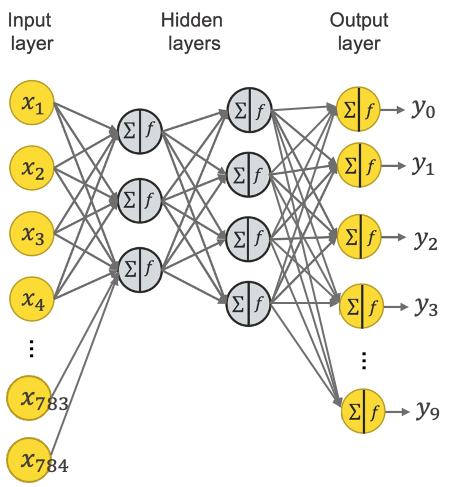



As shown above, the input layer has 784 neurons to fit in all pixels within each 2D image from MNIST, which has a 28x28 pixels.

The output layer has 10 neurons, corresponding to the label being 0, 1, 2, ..., 9. 

The goal is to have only one of the neurons being 1 and this neuron corresponds to the label of the image (i.e., the number of the handwirrent digit). All remain neurons should be 0.

In the middle, let's do only one hidden layer with 64 nodes. 

All neurons are fully connected.

We implement ReLU, sigmoid and softmax activation functions. SGD and Momentum optimizer are available.

Note, we use the softmax activation function in the output layer, since we wish to have probabilities of each class, so that we can measure how well our current forward pass performs.

## Useful packages

In [1]:
# Let's work within our working directory, e.g., where MNIST data is stored
import os
os.chdir('/home/563/yq5547/notebooks/ASTR4004')

# We need numpy to handle data and array
import numpy as np

# We need matplotlib.pyplot to make plots
import matplotlib.pyplot as plt

## Dataset preparation
MNIST contains 70,000 images of handwritten digits, in greyscale with pixel-values from 0 to 255. Let us first load the data. I have store them in two seperated numpy files.

In [2]:
# load data
images = np.load('./MNIST_images.npy', allow_pickle=True)
labels = np.load('./MNIST_labels.npy', allow_pickle=True)

# it is normally a good practice to rescale the training data into [0, 1] or [-1, 1]
images = (images - np.min(images)) / (np.max(images) - np.min(images))

# flatten images into 1D array
x = images.reshape([len(labels), -1])
# create a one-hot encoding of the labels of size 10, i.e., #
# when label is 1, the array is [1, 0, 0, ..., 0]
# when label is 2, the array is [0, 1, 0, ..., 0]
# ...
# when label is 9, the array is [0, 0, 0, ..., 9]
y = np.array(labels.astype('int32')[:, None] == np.arange(10), dtype=np.float32)

### Let's visualize them

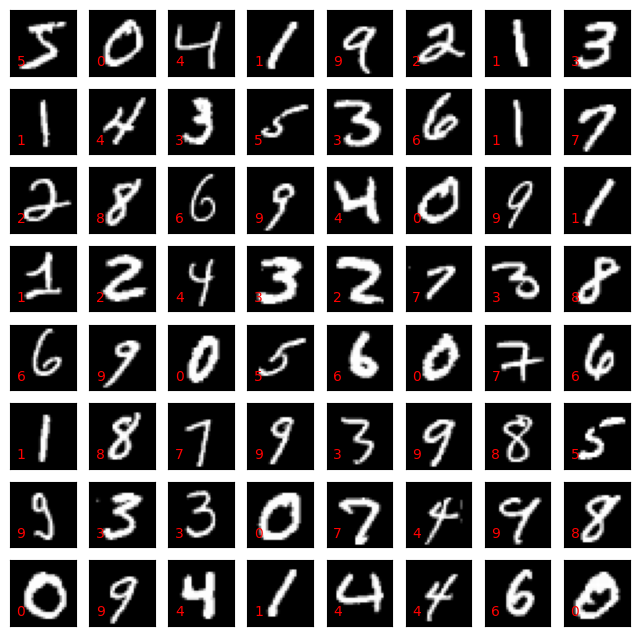

In [3]:
num_row = 8
num_col = 8
fig, axes = plt.subplots(num_row, num_col, figsize=(num_col,num_row))
axes = axes.flatten()

for i in range(num_row*num_col):
    #ax = axes[i//num_col, i%num_col]
    ax = axes[i]
    ax.imshow(images[i], cmap='gray', vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(0.1,0.1, labels[i], va='bottom', ha='left', transform=ax.transAxes, color='r')

### Let's divide the sample into training (70%), validation (20%) and test (10%) 

In [4]:
train_size = int(0.7 * len(x))
valid_size = int(0.2 * len(x))
test_size = len(x) - train_size - valid_size

x_train, x_valid, x_test = x[:train_size], x[train_size:train_size+valid_size], x[-test_size:]
y_train, y_valid, y_test = y[:train_size], y[train_size:train_size+valid_size], y[-test_size:]
images_test, labels_test = images[-test_size:], labels[-test_size:]

print("Training data: {} {}".format(x_train.shape, y_train.shape))
print("Validation data: {} {}".format(x_valid.shape, y_valid.shape))
print("Test data: {} {}".format(x_test.shape, y_test.shape))

Training data: (49000, 784) (49000, 10)
Validation data: (14000, 784) (14000, 10)
Test data: (7000, 784) (7000, 10)


### It is often a good practice to reshuffle the training set to get rid of any existing pattern in the data

In [5]:
shuffle_index = np.random.permutation(train_size)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]
shuffle_index = np.random.permutation(valid_size)
x_valid, y_valid = x_valid[shuffle_index], y_valid[shuffle_index]
shuffle_index = np.random.permutation(test_size)
x_test, y_test = x_test[shuffle_index], y_test[shuffle_index]
images_test, labels_test = images_test[shuffle_index], labels_test[shuffle_index]

## Network definition

### activation functions (σ)

In [6]:
def relu(x):
    '''
    relu(x) = max(0,x)
    '''
    return np.maximum(0,x)

def sigmoid(x):
    '''
    sigmoid(x) = 1 / 1+exp(-x)
    '''
    return 1 / (1+np.exp(-x))

def softmax(x):
    '''
    softmax(x) = exp(x) / ∑exp(x)
    '''
    exps = np.exp(x - np.max(x)) # this makes large exponentials numerically stable
    return exps / np.sum(exps, axis=1)[:,None]

def relu_derivative(x):
    '''
    ∇relu(x) = 0, if x<0
               1, otherwise
    '''
    results = np.ones_like(x)
    results[x<0] = 0
    return results
    
def sigmoid_derivative(x):
    '''
        ∇sigmoid(x) = sigmoid(x)*(1-sigmoid(x))
    '''
    return sigmoid(x) * (1-sigmoid(x))

# let's try sigmoid
def activation(x):
    return sigmoid(x)

def activation_derivative(x):
    return sigmoid_derivative(x)

### network architecture

In [7]:
# let's define the number of neurons in each layer first
input_layer = 784
hidden_layer = 128
output_layer = 10

In [8]:
# then we need to initialize the weights and biases in each neuron
w1 = np.zeros([hidden_layer, input_layer])
b1 = np.zeros([hidden_layer,1])
w2 = np.zeros([output_layer, hidden_layer])
b2 = np.zeros([output_layer,1])

w1 += 0.5
w2 += 0.5

### feed forward

To get through each layer, we sequentially apply the matrix multiplication, followed by the activation function. 

The following matrix multiplication can be done using one line with `numpy.matmul: z = matmul(w, x.T)+b`

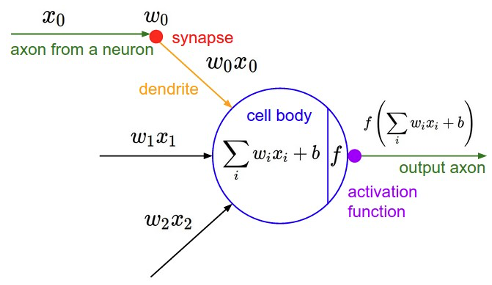

$z_{j} = \Sigma_{i}\left( w_{j,i} \times x_i\right)+b_j; y_{j} = \sigma(z_{j})$

$
 \begin{bmatrix}
     z_{0} \\
     z_{1} \\
     \vdots\\
     z_{127} 
 \end{bmatrix} = 
 \begin{bmatrix}
     w_{0,0} & w_{0,1} & \cdots & w_{0,783}\\
     w_{1,0} & w_{1,1} & \cdots & w_{1,783}\\ 
     \vdots & \vdots & \ddots & \vdots\\ 
     w_{127,0} & w_{127,1} & \cdots & w_{127,783} 
 \end{bmatrix}
  \times
  \begin{bmatrix}
     x_{0}\\
     x_{1}\\
     \vdots\\  
     x_{783}
 \end{bmatrix}
 +
 \begin{bmatrix}
     b_{0}\\
     b_{1}\\
     \vdots \\ 
     b_{127} 
 \end{bmatrix}
$

In [9]:
# defining how the neuron works
def f_z(x,w,b):
    return (np.matmul(w, x.T)+b).T

def f_y1(x, w1, b1):
    z1 = f_z(x, w1, b1)
    return activation(z1)

def f_y2(y1, w2, b2):
    z2 = f_z(y1, w2, b2)
    return softmax(z2)

def feed_forward(x,w1,b1,w2,b2):
    y1 = f_y1(x, w1, b1)
    y2 = f_y2(y1, w2, b2)
    return y2

### why are we using softmax function in the output layer?

The mathematical definition of softmax is that for a given vector of $\begin{bmatrix}
     z_{0} &
     z_{1} &
     \cdots&
     z_{9} 
 \end{bmatrix} $, the softmax function returns $\sigma(z_{i})=e^{z_{i}}/\Sigma e^{z_{i}}$, i.e., $\begin{bmatrix}
     e^{z_{0}}/ \Sigma e^{z_{i}}&
     e^{z_{1}}/ \Sigma e^{z_{i}} &
     \cdots&
     e^{z_{9}}/\Sigma e^{z_{i}} 
 \end{bmatrix} $.

 This naturally gives $\Sigma \sigma(z_{i})=1$, and therefore each $\sigma(z_{i})$ represents the probability of the output. In another word, the probability of the input being 0, 1, ... or 9

### let's visualize how the initial network behaves

Text(0, 0.5, 'Probability')

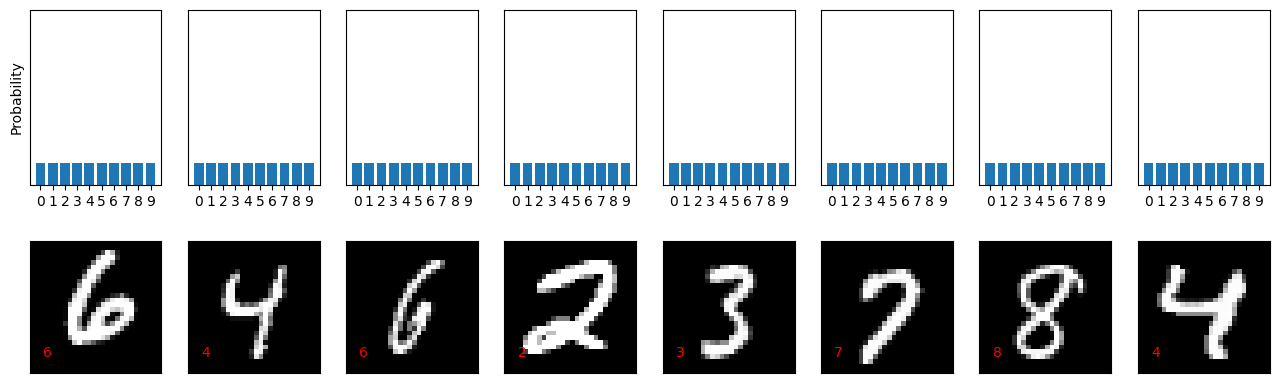

In [10]:
num_col = 8
fig, axes = plt.subplots(2, num_col, figsize=(num_col*2,5))
output = feed_forward(x_test[:num_col], w1, b1, w2, b2)

for i in range(num_col):
    ax = axes[1,i]
    ax.imshow(images_test[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(0.1,0.1, labels_test[i], va='bottom', ha='left', transform=ax.transAxes, color='r')
    axp = axes[0,i]
    axp.bar(np.arange(10), output[i])
    axp.set_xticks(np.arange(10))
    axp.set_yticks([])
    axp.set_ylim(0,0.8)
axes[0,0].set_ylabel('Probability')

<font color='red'>Pretty bad!!</font> and balanced because of the equal weights set above.


In [11]:
# you can also initialize the weights using a Normal distribution with a variance corresponding to 1/#neurons
# This adds a bit randomness in the initial status, I found this makes the training easier!
np.random.seed(1993) # fix your seeds for reproducibility!
w1 = np.random.randn(hidden_layer, input_layer) / (hidden_layer)**0.5
w2 = np.random.randn(output_layer, hidden_layer) / (output_layer)**0.5

## Network training

### cross-entropy loss function

For the task of recognizing handwritten digit, the goal is classify an image into one of the 10 possible digits (0-9). We are using softmax in the output layer to predict the probability of the label being 0, 1, ..., 9.

Cross-entropy, by measuring the difference between two probability distributions (i.e. the true distribution of the labels vs the predicted probability with softmax activation), is one of the best for classification.

With y being the true label (e.g. 1 for label '3' and 0 for all other 9 labels) while ŷ is the prediction, to minimize L(y, ŷ) we need ŷ to be as close to 1 as possible for label '3' and close to 0 for all other 9 labels.



In [12]:
def cross_entropy_loss(y, y2):
    '''
        L(y, ŷ) = −∑ylog(ŷ).
    '''
    return -np.sum(np.multiply(y, np.log(y2)))/len(y)

### Backpropagation and Gradient descent

Let's denote y1 and y2 as the output of the hidden and output layers, respecitvely and y being the real label. We write the loss as

$L(y, y2) = −\sum \limits_{j=0}^{9} y_{j}\log(y2_{j})=−\sum \limits_{j=0}^{9} y_{j}\log(\frac{e^{{z2_{j}}}}{\sum \limits_{j=0}^{9}e^{z2_{j}}})=−\sum \limits_{j=0}^{9} y_{j}\left[z2_{j} - \log({\sum \limits_{j=0}^{9}e^{z2_{j}}})\right]$

now the derivative over $z2_{i}$

$\frac{\partial L}{\partial z2_{i}} = −\sum \limits_{j=0}^{9} y_{j}\left[\frac{\partial z2_{j}}{\partial z2_{i}}  - \frac{\partial \log({\sum \limits_{j=0}^{9}e^{z2_{j}}})}{\partial z2_{i}}\right]=−\sum \limits_{j=0}^{9} y_{j}\left[\delta_{ji} -  \frac{e^{z2_{i}}}{\sum \limits_{j=0}^{9}e^{z2_{j}}}  \right]=−\sum \limits_{j=0}^{9} y_{j}\delta_{ji} + \sum \limits_{j=0}^{9} y_{j} \frac{e^{z2_{i}}}{\sum \limits_{j=0}^{9}e^{z2_{j}}} =− y_{i} + \frac{e^{z2_{i}}}{\sum \limits_{j=0}^{9}e^{z2_{j}}} =− y_{i} + y2_{i}$

The gradient $\frac{\partial L}{\partial z2_{i}}= + y2_{i}− y_{i}$ has a very straighforward and intuitive interpretation:

* If the network predicts a higher probability for the correct label ($y2_{i}> y_{i}$): the gradient is positive, indicating that the $z2_{i}$ should be decreased to reduce the loss.

* If the network predicts a lower probability for the correct label ($y2_{i}< y_{i}$): the gradient is negative, indicating that the $z2_{i}$ should be increased to reduce the loss.

* For incorrect classes ($y_{i}=0$): the gradient is simply $y2_{i}$, encouraging the network to decrease the probability of incorrect labels

what about gradients over weights and bias? remember $z2_{j} = \Sigma_{i}\left( w2_{j,i} \times y1_i\right)+b2_j$ and <font color='red'>chain rule!</font>

$\frac{\partial L}{\partial w2_{i,j}} = \sum \limits_{j}\frac{\partial L}{\partial z2_{j}} \frac{\partial z2_{j}}{\partial w2_{i,j}} = \sum \limits_{j} \frac{\partial L}{\partial z2_{j}} y1_{j} $

$\frac{\partial L}{\partial b2_{i,j}} = \sum \limits_{j}\frac{\partial L}{\partial z2_{j}} \frac{\partial z2_{j}}{\partial b2_{i,j}} = \sum \limits_{j} \frac{\partial L}{\partial z2_{j}} $

what about the hidden layer? same, $z1_{j} = \Sigma_{i}\left( w1_{j,i} \times x_i\right)+b1_j$ and <font color='red'>more chain rule!</font>

$\frac{\partial L}{\partial z1_{i}} = \sum \limits_{j}\frac{\partial L}{\partial z2_{j}} \frac{\partial z2_{j}}{\partial y1_{i}} \frac{\partial y1_{i}}{\partial z1_{i}} =  \sum \limits_{j} \frac{\partial L}{\partial z2_{j}}w2_{j,i}\frac{\partial y1_{i}}{\partial z1_{i}}$

$\frac{\partial L}{\partial w1_{i,j}} = \sum \limits_{j}\frac{\partial L}{\partial z1_{j}} \frac{\partial z1_{j}}{\partial w1_{i,j}} = \sum \limits_{j} \frac{\partial L}{\partial z1_{j}} x_{j} $

$\frac{\partial L}{\partial b1_{i,j}} = \sum \limits_{j}\frac{\partial L}{\partial z1_{j}} \frac{\partial z1_{j}}{\partial b1_{i,j}} = \sum \limits_{j} \frac{\partial L}{\partial z1_{j}} $

In [13]:
def gradient_descent(x,y,w1,b1,w2,b2):
    z1 = f_z(x, w1, b1)
    y1 = f_y1(x, w1, b1)
    y2 = f_y2(y1, w2, b2)

    dLdz2 = y2-y

    dLdw2 = np.matmul(dLdz2.T, y1) / len(y1)

    dLdb2 = np.sum(dLdz2, axis=0).reshape([-1,1]) / len(y1)

    dy1dz1 = activation_derivative(z1)

    dLdz1 = np.matmul(dLdz2, w2) * dy1dz1

    dLdw1 = np.matmul(dLdz1.T, x) / len(y1) 
    dLdb1 = np.sum(dLdz1, axis=0).reshape([-1,1]) / len(y1) 

    return {'dLdw1': dLdw1, 'dLdw2': dLdw2, 'dLdb1': dLdb1, 'dLdb2': dLdb2}

### Okay, now let's train the network

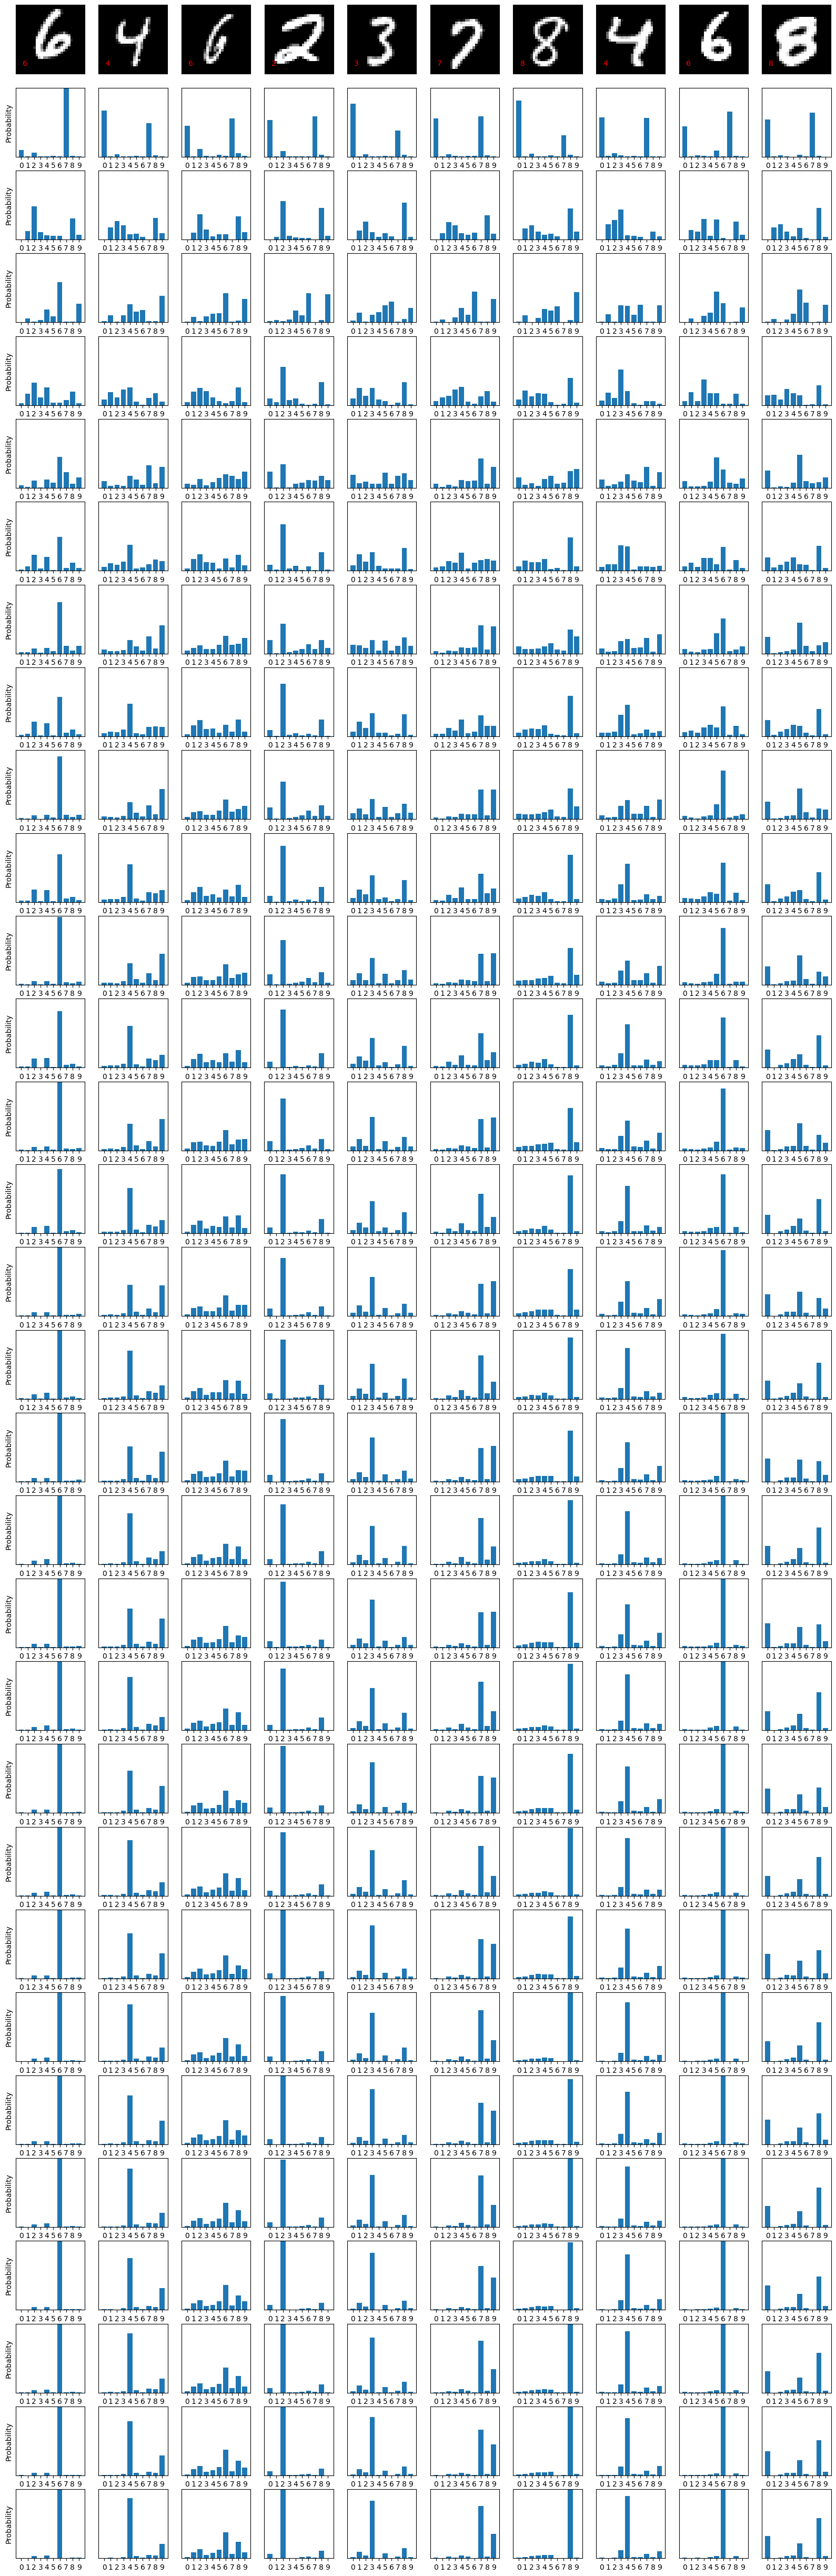

In [14]:
num_col = 10 # visualize 10 images from test set
l_rate = 0.4 # learning rate
Nepoch = 30  # train for only 30 steps
loss_train = np.zeros(Nepoch) # we will store the loss function for the training set
loss_valid = np.zeros(Nepoch) # and validation

fig, axes = plt.subplots(Nepoch+1, num_col, figsize=(num_col*2, 3+Nepoch*2))

# let's show the images on the first row
for i in range(num_col):
    ax = axes[0,i]
    ax.imshow(images_test[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(0.1,0.1, labels_test[i], va='bottom', ha='left', transform=ax.transAxes, color='r')

for step in range(Nepoch):
    # calculate the loss using both training and validation sets
    output_train = feed_forward(x_train, w1, b1, w2, b2)
    loss_train[step] = cross_entropy_loss(y_train, output_train)
    output_valid = feed_forward(x_valid, w1, b1, w2, b2)
    loss_valid[step] = cross_entropy_loss(y_valid, output_valid)

    # illustrate the performance using the test set
    output_test = feed_forward(x_test[:num_col], w1, b1, w2, b2)

    # calculate the gradient and update the weights
    grad = gradient_descent(x_train, y_train, w1, b1, w2, b2)
    w1 = w1 - l_rate * grad['dLdw1']
    b1 = b1 - l_rate * grad['dLdb1']
    w2 = w2 - l_rate * grad['dLdw2']
    b2 = b2 - l_rate * grad['dLdb2']

    # show the prediction
    for i in range(num_col):
        axp = axes[1+step,i]
        axp.bar(np.arange(10), output_test[i])
        axp.set_xticks(np.arange(10))
        axp.set_yticks([])
        axp.set_ylim(0,0.8)
    axes[step+1, 0].set_ylabel('Probability')

pretty good, huh? 

The second image is a '4' but it does look very like a '9'
The third image which is a '6' seems to be a bit difficult to recognize, but we do start to see a peak at 6 in the prediction. So with more training, it should get better. You will see below that the loss is not converged yet, meaning that we can still improve it!

### Let's view the loss

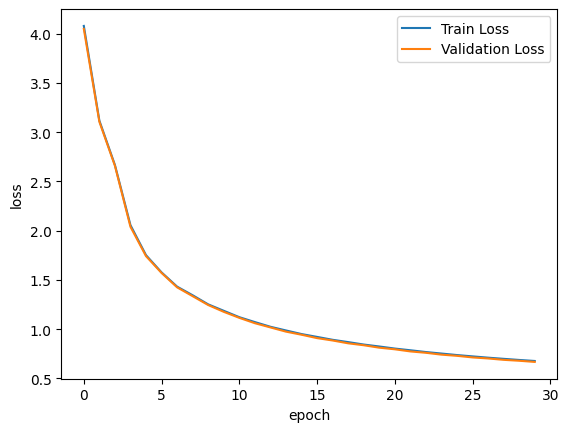

In [15]:
fig, ax = plt.subplots(1,1)
ax.plot(loss_train, label='Train Loss')
ax.plot(loss_valid, label='Validation Loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(loc='upper right')

<font color='red'> Please go back and try a different learning rate or activation functions (either using relu or other self-defined ones) to explore how they affect the training process and results </font>
you can also explore how softmax in the output layer impacts the network

## Finally, let's talk about one more thing, which is batch size

Our training set has 49000 entries, and we have been using all of them in each step of training. This is referred to as Batch Gradient Descent (Full Batch)

Here, batch size refers to the number of training samples utilized in one forward and backward pass through the neural network during the training process.

The choice of batch size affects the training dynamics, computational resources, and the model's ability to generalize to unseen data.

#### Full Batch (Batch Size = total number of traning data) 
* Because all data is used in Full Batch, the training is stable and accurate gradient estimates and deterministic convergence path.
* However, it is computationally expensive as it requires a large memory to process all the data, which sometimes isn't practical

#### Stochastic Gradient Descent (Batch Size = 1)
* Because only one sample is used to calculate gradient, convergence can be slow due to noisy updates and sometimes unstable.
* It is also less efficient for parallel computations
* But because of the stochasticity, it is good at escaping local minima and therefore can sometimes converge quicker.

#### Mini-Batch Gradient Descent (something in the middle)
* Balances between stability and efficiency
* Exploits hardware parallelisim
* Choice of batch size is somewhat abitrary and can significantly impact training dynamics
* Requires tuning of the hyperparameters such as the learning rate
* Common choices of batch size include 32, 64, 128, 256. Rule of thumb is to start with 32 or 64 and adjust based on performance and hardware capabilities.

### let's try a mini-batch training 
remember to reinitialize the weights if you want a fair comparison!

In [22]:
np.random.seed(1993) # same seed for comparison
b1 = np.zeros([hidden_layer,1])
b2 = np.zeros([output_layer,1])
w1 = np.random.randn(hidden_layer, input_layer) / (hidden_layer)**0.5
w2 = np.random.randn(output_layer, hidden_layer) / (output_layer)**0.5

(0.0, 1.0)

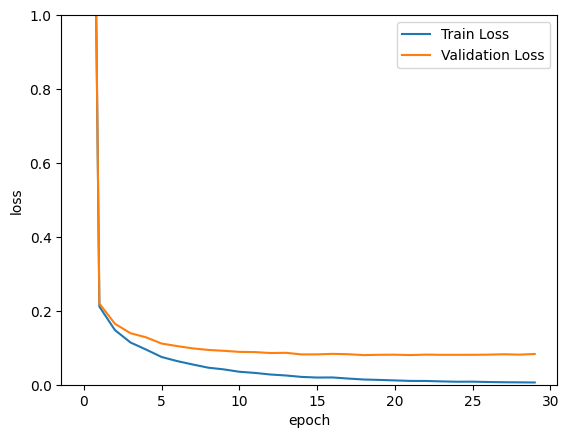

In [24]:
loss_train = np.zeros(Nepoch)
loss_valid = np.zeros(Nepoch)

######## Mini-batch #########
batch_size = 32
num_batches = train_size // batch_size
#############################

for step in range(Nepoch):

    # calculate the loss using both training and validation sets
    output_train = feed_forward(x_train, w1, b1, w2, b2)
    loss_train[step] = cross_entropy_loss(y_train, output_train)
    output_valid = feed_forward(x_valid, w1, b1, w2, b2)
    loss_valid[step] = cross_entropy_loss(y_valid, output_valid)

    # shuffle the training set for every step
    shuffle_index = np.random.permutation(train_size)
    x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]
    for j in range(num_batches):
        # selecting the mini batch
        index_left = j*batch_size
        index_right = index_left + batch_size
        if index_right >= train_size: 
            index_right = train_size-1

        # calculate the gradient and update the weights
        grad = gradient_descent(x_train[index_left:index_right], y_train[index_left:index_right], w1, b1, w2, b2)
        w1 = w1 - l_rate * grad['dLdw1']
        b1 = b1 - l_rate * grad['dLdb1']
        w2 = w2 - l_rate * grad['dLdw2']
        b2 = b2 - l_rate * grad['dLdb2']
        
fig, ax = plt.subplots(1,1)
ax.plot(loss_train, label='Train Loss')
ax.plot(loss_valid, label='Validation Loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(loc='upper right')
ax.set_ylim(0,1)

loss seems to reduce much faster in particular at the initial stage! We also start to see the difference between validation and traininig losses.